# Clusterização da MEIP por Zona OD, considerando ou não a vizinhança

O método proposto vai clusterizar por k-medioides e de maneira hierarquica, primeiramente sem considerar a vizinhança e depois comparando com duas propostas. A primeira adicionando às dimensões, um índice local de Moran para cada dimensão e a outra considerando apenas essa nova dimensão calculada.

Para avaliar os resultados propomos a aplicação do método SHAP para compreender os agrupamentos e a relevância de cada dimensão para cada estratégia utilizada

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
df_meip = pd.read_csv('data/df_meip.csv', sep=';', decimal=',')\
    .set_index('od_id')

In [3]:
gdf_od = gpd.read_file('data/zonas-OD-2017-São-Paulo.gpkg')

## Dimensões

In [4]:
import seaborn as sns

In [5]:
# demanda = [
#     "prod_desl_pe",
#     "atra_desl_pe",
# ]

# sinistros = [
#     "atrop_tot",
#     "atrop_fer",
#     "atrop_fat",
#     "fatalid"
# ]

# faixas_pedestre = [
#     "faixas_detectadas",
#     "demanda_faixas",
#     "prop_atendida"
# ]

modelo = [
    "desl_pe",
    "atrop_tot",
    "fatalid",
    "prop_atendida",
    "perc_nao_resid",
    "ca_medio",
    "dens_onibus",
    "dens_mass",
    "prop_via_interm",
    "prop_via_rapida"
]

In [6]:
df_meip.columns

Index(['atrop_tot', 'atrop_fer', 'atrop_fat', 'fatalid', 'prod_desl_pe',
       'atra_desl_pe', 'faixas_detectadas', 'demanda_faixas', 'prop_atendida',
       'ext_tot', 'prop_art', 'prop_col', 'prop_loc', 'prop_ped', 'prop_vtr',
       'prop_rod', 'ca_medio', 'perc_comercial', 'perc_residencial',
       'perc_outros_usos', 'dens_onibus', 'dens_mass', 'perc_nao_resid',
       'prop_via_lenta', 'prop_via_interm', 'prop_via_rapida', 'desl_pe'],
      dtype='object')

<AxesSubplot: >

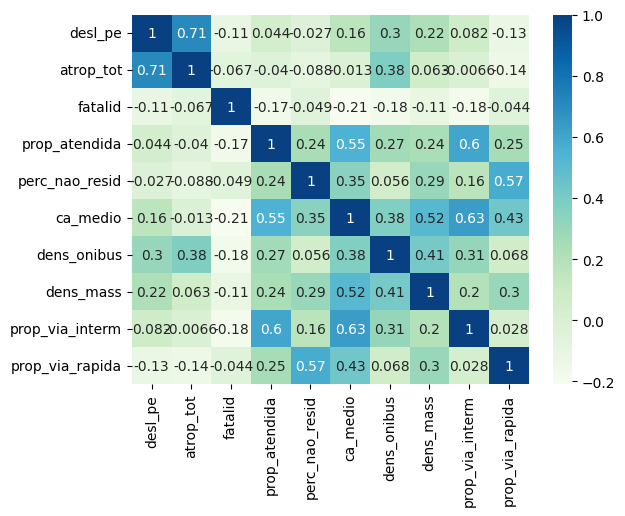

In [7]:
correlacao_modelo = df_meip[modelo].corr()
sns.heatmap(correlacao_modelo, cmap="GnBu", annot=True)

In [8]:
# sns.pairplot(df_meip[modelo])

## K-Clusterização

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [10]:
scaler = MinMaxScaler((-1,1))
# scaler = StandardScaler()

In [11]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

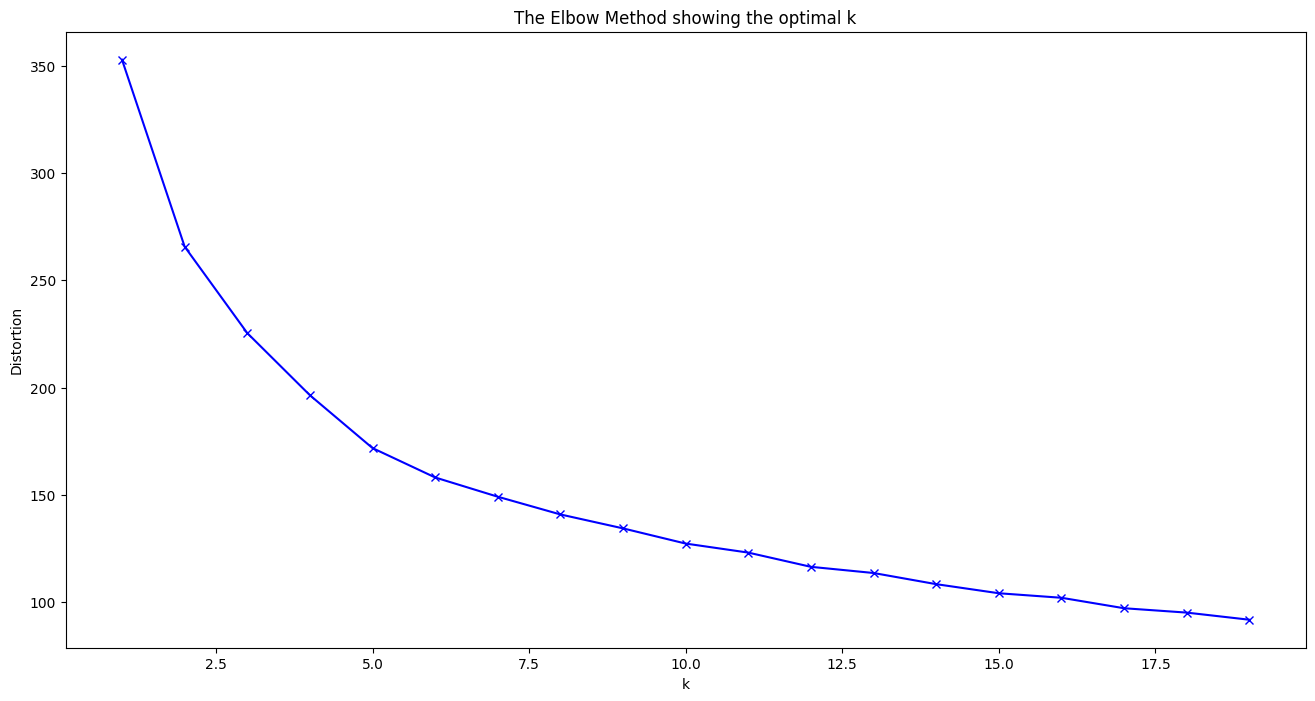

In [12]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot: >

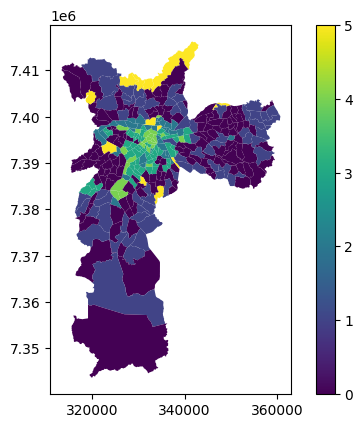

In [13]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[modelo]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)

## Clusterização hierarquica

In [14]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

In [15]:
# Z = linkage(df_meip[modelo], 'centroid')
Z = linkage(scaler.fit_transform(df_meip[modelo]), 'ward')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [10.0, 10.0, 40.0, 40.0]],
 'dcoord': [[0.0, 7.022042785123251, 7.022042785123251, 0.0],
  [0.0, 5.711529550310805, 5.711529550310805, 0.0],
  [0.0, 7.425731059406491, 7.425731059406491, 0.0],
  [5.711529550310805, 8.04758235258071, 8.04758235258071, 7.425731059406491],
  [7.022042785123251,
   12.991377288269687,
   12.991377288269687,
   8.04758235258071]],
 'ivl': ['(114)', '(86)', '(8)', '(45)', '(15)', '(74)'],
 'leaves': [673, 676, 669, 674, 672, 677],
 'color_list': ['C1', 'C2', 'C2', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2', 'C2', 'C2']}

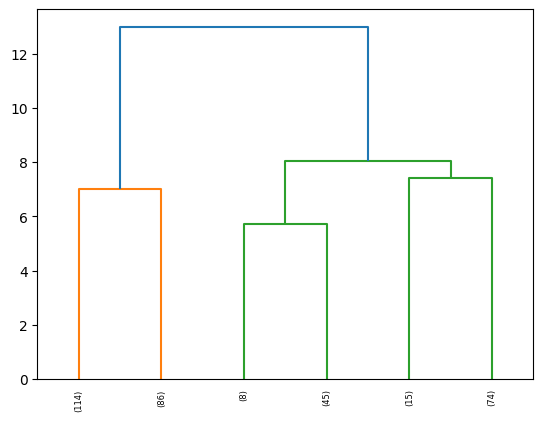

In [16]:
dendrogram(Z, leaf_rotation=90, leaf_font_size=6, labels=df_meip.index, truncate_mode = 'lastp', p=6, show_leaf_counts=True)
# dendrogram(Z, leaf_rotation=90, leaf_font_size=6)

In [17]:
df_meip['h_cluster'] = fcluster(Z, t=6, criterion='maxclust')

In [18]:
np.unique(fcluster(Z, t=6, criterion='maxclust'), return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int32), array([114,  86,   8,  45,  15,  74]))

In [19]:
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')

<AxesSubplot: >

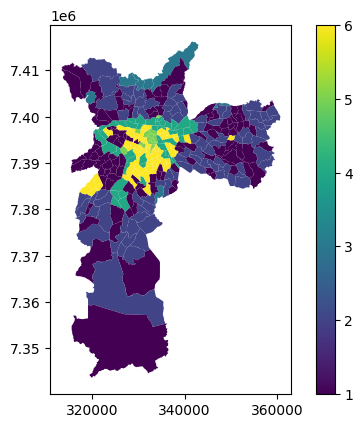

In [20]:
gdf_zona_merged.plot(column='h_cluster', legend=True)

## Matriz de vizinhança

In [21]:
import libpysal as lps

In [22]:
wq = lps.weights.Queen.from_dataframe(gdf_od)

In [23]:
wq.transform = 'r'

In [24]:
for m in modelo:
    df_meip[f'{m}_vizinhos'] = lps.weights.lag_spatial(wq, df_meip[m])

In [25]:
modelo_vizinhanca = modelo + [m + "_vizinhos" for m in modelo]

## Clusterização K+vizinhança

In [26]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
    # kmeanModel.fit(scaler.fit_transform(df_meip))
    distortions.append(kmeanModel.inertia_)

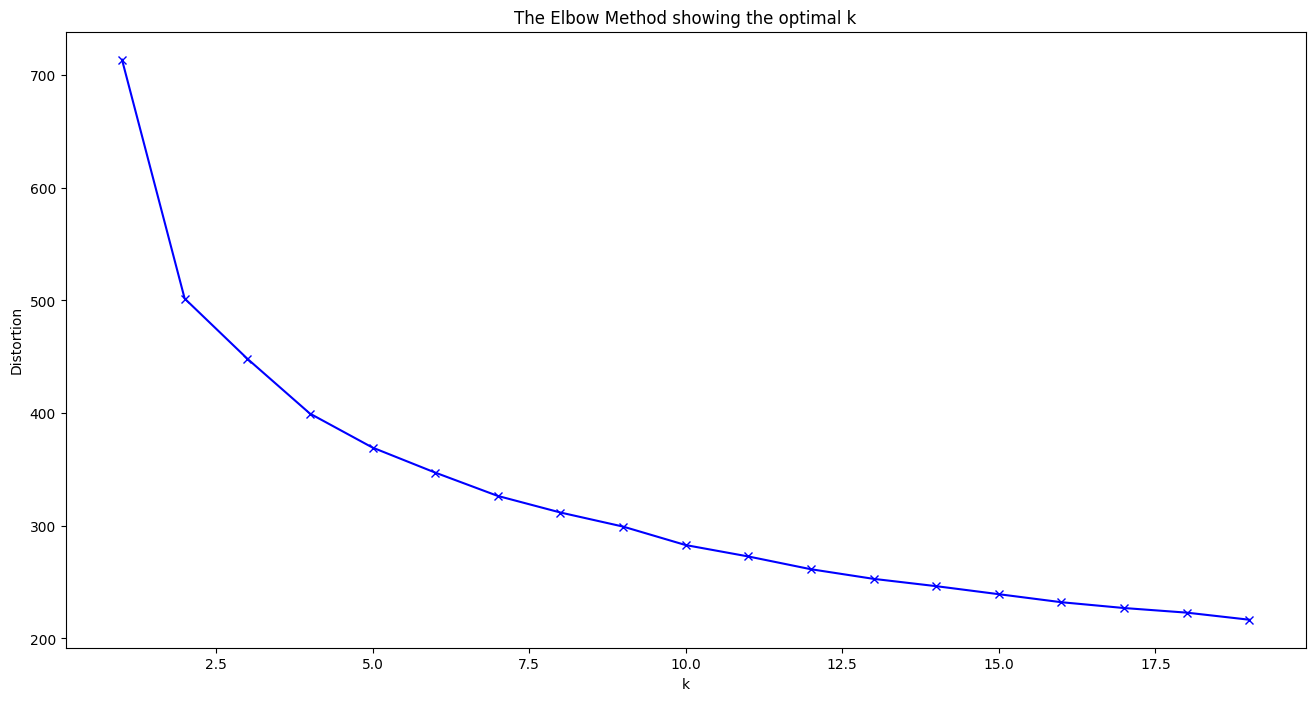

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<AxesSubplot: >

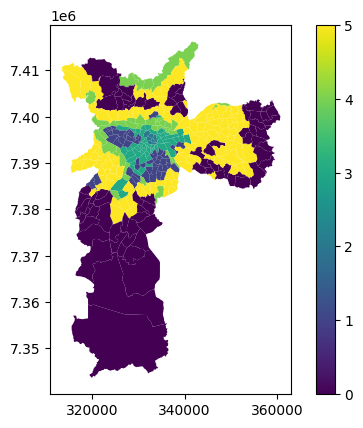

In [31]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[modelo_vizinhanca]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)

## Clusterização somente da vizinhança

<AxesSubplot: >

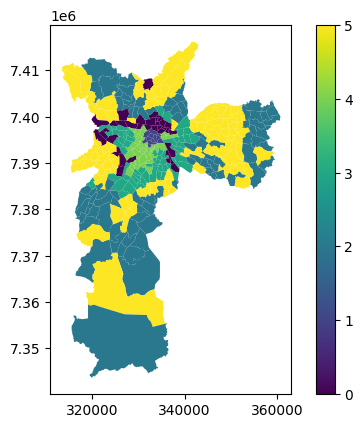

In [29]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(scaler.fit_transform(df_meip[[m + "_vizinhos" for m in modelo]]))
df_meip['k_cluster'] = kmeans.labels_
gdf_zona_merged = gdf_od.merge(df_meip.reset_index(), left_on='NumeroZona', right_on='od_id')
gdf_zona_merged.plot(column='k_cluster', legend=True)